In [1]:
from pyspark.ml import Pipeline
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.sql.types import IntegerType

In [2]:
spark = SparkSession.builder \
        .master('local[*]') \
        .appName('first_spark_application') \
        .getOrCreate() #if there is a active session it will get or create one

In [3]:
# loading data 

health = spark.read.csv('train.csv', header=True, inferSchema=True)

# Exploratory Data Analysis

## Data Description

### column type , name and count

In [4]:
health.dtypes

[('id', 'int'),
 ('Gender', 'string'),
 ('Age', 'int'),
 ('Driving_License', 'int'),
 ('Region_Code', 'double'),
 ('Previously_Insured', 'int'),
 ('Vehicle_Age', 'string'),
 ('Vehicle_Damage', 'string'),
 ('Annual_Premium', 'double'),
 ('Policy_Sales_Channel', 'double'),
 ('Vintage', 'int'),
 ('Response', 'int')]

In [5]:
print('Number of rows: '+ format(health.count()) +', number of features: '+ format(len(health.dtypes)))


Number of rows: 381109, number of features: 12


In [6]:
# we will not use id so its better to drop it
health = health.drop('id')

### Miss value

In [7]:
for i in range(len(health.dtypes)):
    if health.select(health[i]).count() != health.count():
        print(str(i+1)+" : " +str(health.select(health[i]).count()))
    else:
        print("No miss value in "+ str(i+1) +"th column")

No miss value in 1th column
No miss value in 2th column
No miss value in 3th column
No miss value in 4th column
No miss value in 5th column
No miss value in 6th column
No miss value in 7th column
No miss value in 8th column
No miss value in 9th column
No miss value in 10th column
No miss value in 11th column


# Data Understanding

### Dataframe

In [8]:
health.show(5)

+------+---+---------------+-----------+------------------+-----------+--------------+--------------+--------------------+-------+--------+
|Gender|Age|Driving_License|Region_Code|Previously_Insured|Vehicle_Age|Vehicle_Damage|Annual_Premium|Policy_Sales_Channel|Vintage|Response|
+------+---+---------------+-----------+------------------+-----------+--------------+--------------+--------------------+-------+--------+
|  Male| 44|              1|       28.0|                 0|  > 2 Years|           Yes|       40454.0|                26.0|    217|       1|
|  Male| 76|              1|        3.0|                 0|   1-2 Year|            No|       33536.0|                26.0|    183|       0|
|  Male| 47|              1|       28.0|                 0|  > 2 Years|           Yes|       38294.0|                26.0|     27|       1|
|  Male| 21|              1|       11.0|                 1|   < 1 Year|            No|       28619.0|               152.0|    203|       0|
|Female| 29|        

### Max ,Min,Mean...

In [9]:
health.describe().show()


+-------+------+------------------+-------------------+------------------+------------------+-----------+--------------+------------------+--------------------+------------------+-------------------+
|summary|Gender|               Age|    Driving_License|       Region_Code|Previously_Insured|Vehicle_Age|Vehicle_Damage|    Annual_Premium|Policy_Sales_Channel|           Vintage|           Response|
+-------+------+------------------+-------------------+------------------+------------------+-----------+--------------+------------------+--------------------+------------------+-------------------+
|  count|381109|            381109|             381109|            381109|            381109|     381109|        381109|            381109|              381109|            381109|             381109|
|   mean|  null|38.822583565331705| 0.9978693759528114|26.388807401557035|0.4582101183650871|       null|          null|30564.389581458323|  112.03429465061177|154.34739667654136|0.12256336113815208|


## Featuers distributions

####  (Method:Aggregation using Group By and Plot)

Aggregation using Group By --> Pandas --> Plot

### Number of distinct values for each attribute

In [10]:
Numeric = ["Age",'Annual_Premium','Vintage']
Category = ["Gender","Driving_License","Previously_Insured","Region_Code","Vehicle_Age",'Policy_Sales_Channel','Vehicle_Damage']
Target=["Response"]
Features = Numeric + Category +Target

In [11]:
for i in Features:
    print(i,":",health.select(health[i]).distinct().count())

Age : 66
Annual_Premium : 48838
Vintage : 290
Gender : 2
Driving_License : 2
Previously_Insured : 2
Region_Code : 53
Vehicle_Age : 3
Policy_Sales_Channel : 155
Vehicle_Damage : 2
Response : 2


### Target Variable (Response)

1 : Customer is interested, 0 : Customer is not interested

In [12]:
targetCount = health.groupBy(["Response"]).count().toPandas()

In [13]:
targetCount

,Response,count
0,1,46710
1,0,334399


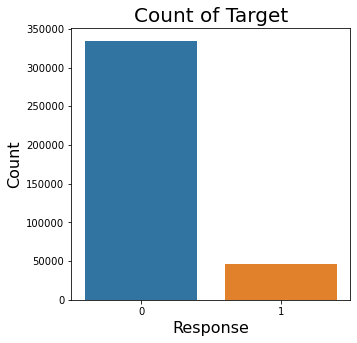

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

fig,ax1 = plt.subplots(nrows = 1, ncols = 1, sharex = False, figsize = (5,5))
sns.barplot(targetCount["Response"],targetCount["count"], ax = ax1, ci = None)
ax1.set_title("Count of Target", fontsize = 20)
ax1.set_xlabel("Response",fontsize = 16); ax1.set_ylabel("Count",fontsize = 16)
plt.show()

### Numeric Featuers

### By Age

In [15]:
health.describe('Age').show()

+-------+------------------+
|summary|               Age|
+-------+------------------+
|  count|            381109|
|   mean|38.822583565331705|
| stddev|15.511611018095321|
|    min|                20|
|    max|                85|
+-------+------------------+



In [16]:
ageCount = health.groupBy(["Age", "Response"]).count().toPandas()
avgPremiumByAge = health.groupBy(["Age", "Response"]).avg("Annual_Premium").withColumnRenamed("avg(Annual_Premium)","Avg_Annual_Premium").toPandas()

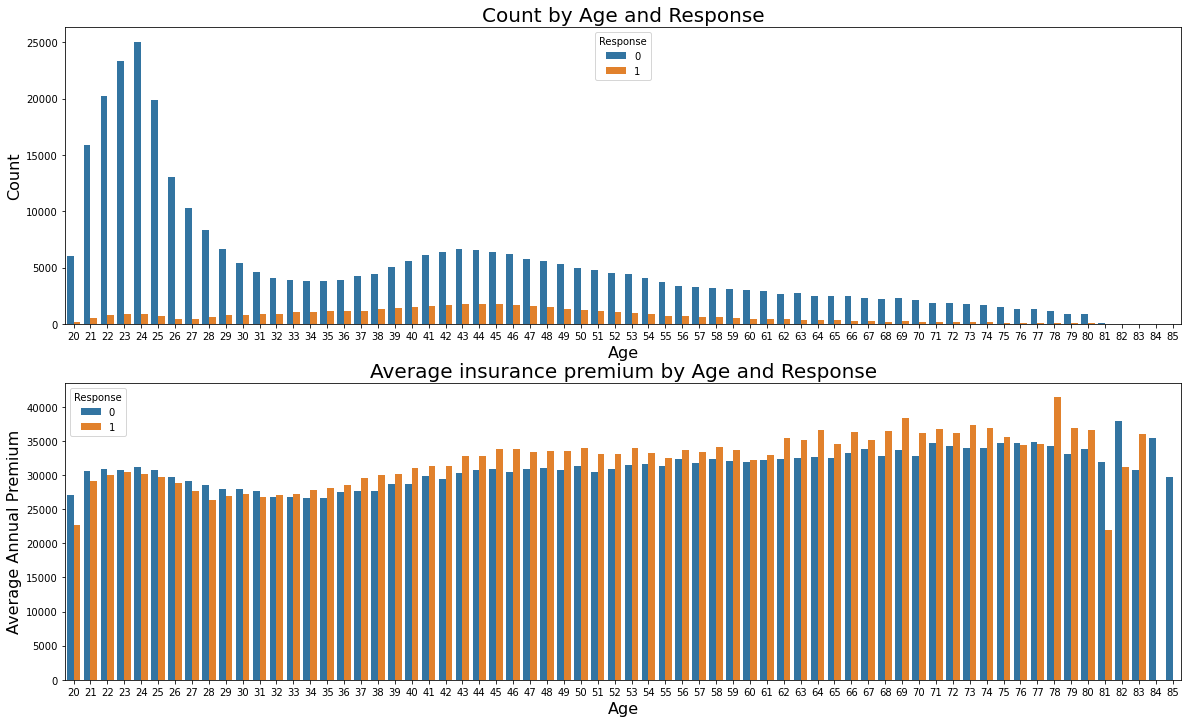

In [17]:
fig, (ax1, ax2) = plt.subplots(nrows = 2, ncols = 1, sharex = False, figsize = (20, 12))

sns.barplot(ageCount["Age"], ageCount["count"], hue = ageCount["Response"], ax = ax1)
ax1.set_title("Count by Age and Response", fontsize = 20)
ax1.set_xlabel("Age",fontsize = 16); ax1.set_ylabel("Count",fontsize = 16)



sns.barplot(avgPremiumByAge["Age"], avgPremiumByAge["Avg_Annual_Premium"], hue = avgPremiumByAge["Response"],ax = ax2)
ax2.set_xlabel("Age",fontsize = 16); ax2.set_ylabel("Average Annual Premium",fontsize = 16)
ax2.set_title("Average insurance premium by Age and Response", fontsize = 20)



plt.show()

### By Vintage

In [18]:
VintageCount = health.groupBy(["Vintage", "Response"]).count().toPandas()

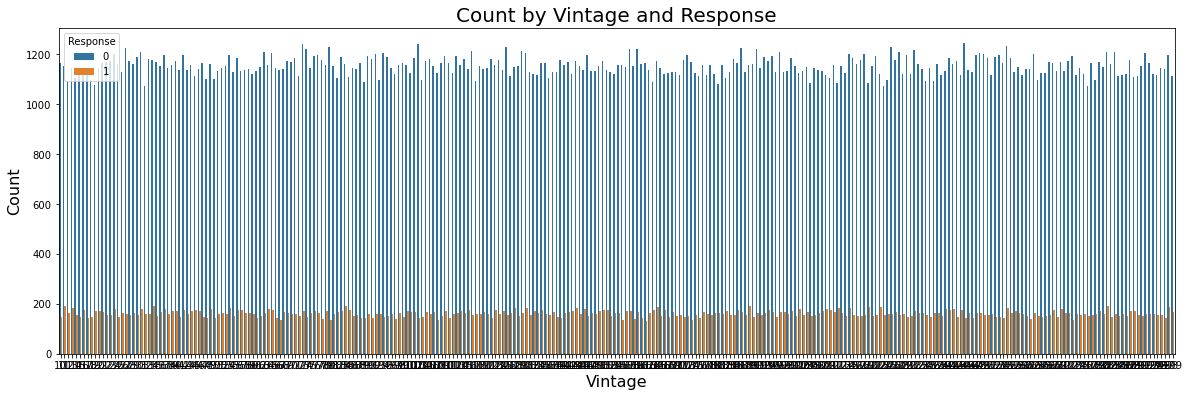

In [19]:
fig, (ax2) = plt.subplots(nrows = 1, ncols = 1, sharex = False, figsize = (20, 6))

sns.barplot(VintageCount["Vintage"], VintageCount["count"], hue = VintageCount["Response"], ax = ax2)
ax2.set_title("Count by Vintage and Response", fontsize = 20)
ax2.set_xlabel("Vintage",fontsize = 16); ax2.set_ylabel("Count",fontsize = 16)


plt.show()

### Binary Featuers

### By gender

In [20]:
genderCount = health.groupBy(["Gender","Response"]).count().toPandas()


In [21]:
genderCount

,Gender,Response,count
0,Male,1,28525
1,Female,0,156835
2,Male,0,177564
3,Female,1,18185


In [22]:
MResPer=health.filter(health['Gender']=='Male').filter(health['Response']=='1').count() /health.filter(health['Gender']=='Male').count()
FeResPer=health.filter(health['Gender']=='Female').filter(health['Response']=='1').count()/health.filter(health['Gender']=='Female').count()

print("Male Response Rate :",str(round(100 *MResPer,3)),"%")
print("Female Response Rate :", str(round(100 *FeResPer,3)),"%")

Male Response Rate : 13.841 %
Female Response Rate : 10.39 %


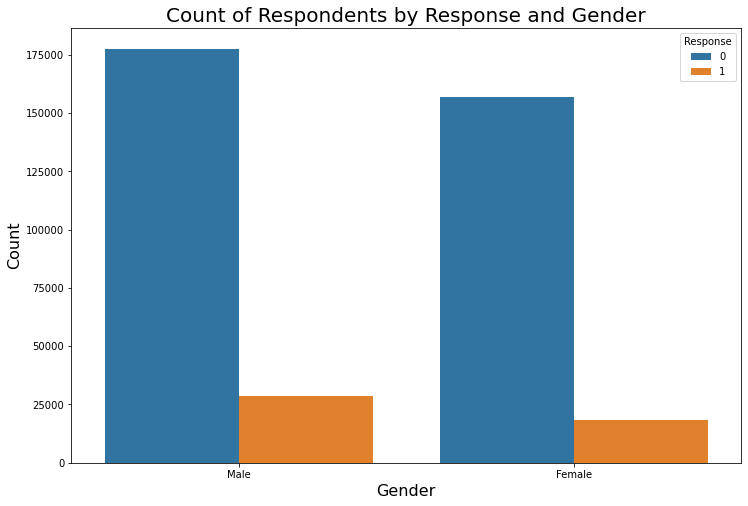

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

fig,ax1 = plt.subplots(nrows = 1, ncols = 1, sharex = False, figsize = (12, 8))
sns.barplot(genderCount["Gender"], genderCount["count"], hue = genderCount["Response"], ax = ax1, ci = None)
ax1.set_title("Count of Respondents by Response and Gender", fontsize = 20)
ax1.set_xlabel("Gender",fontsize = 16); ax1.set_ylabel("Count",fontsize = 16)
plt.show()

In [24]:
health.crosstab('Gender',"Response").show()

+---------------+------+-----+
|Gender_Response|     0|    1|
+---------------+------+-----+
|           Male|177564|28525|
|         Female|156835|18185|
+---------------+------+-----+



### By Driving_License

0 : Customer does not have DL, 1 : Customer already has DL

In [25]:
NResPer=health.filter(health['Driving_License']== 0).filter(health['Response']=='1').count() /health.filter(health['Driving_License']== 0).count()
YResPer=health.filter(health['Driving_License']== 1).filter(health['Response']=='1').count()/health.filter(health['Driving_License']== 1).count()
DLPer=health.filter(health['Driving_License']== 1).count() /health.count()

print("No Driving License Response Rate :",str(round(100 *NResPer,3)),"%")
print("Have Driving License Response Rate :", str(round(100 *YResPer,3)),"%")
print("------------------------------------------------------------------")
print("Have Driving License Rate :", str(round(100 *DLPer,3)),"%")

No Driving License Response Rate : 5.049 %
Have Driving License Response Rate : 12.272 %
------------------------------------------------------------------
Have Driving License Rate : 99.787 %


### By Previously_Insured

1 : Customer already has Vehicle Insurance, 0 : Customer doesn't have Vehicle Insurance

In [26]:
NResPer=health.filter(health['Previously_Insured']== 0).filter(health['Response']=='1').count() /health.filter(health['Previously_Insured']== 0).count()
YResPer=health.filter(health['Previously_Insured']== 1).filter(health['Response']=='1').count()/health.filter(health['Previously_Insured']== 1).count()
PIPer=health.filter(health['Previously_Insured']== 1).count() /health.count()

print("Doesn't have Vehicle Insurance Response Rate  :",str(round(100 *NResPer,3)),"%")
print("Already has Vehicle Insurance Response Rate :", str(round(100 *YResPer,3)),"%")
print("------------------------------------------------------------------")
print("Have Vehicle Insurance Rate :", str(round(100 *PIPer,3)),"%")

Doesn't have Vehicle Insurance Response Rate  : 22.545 %
Already has Vehicle Insurance Response Rate : 0.09 %
------------------------------------------------------------------
Have Vehicle Insurance Rate : 45.821 %


In [27]:
PreviouslyInsuredCount = health.groupBy(['Previously_Insured',"Response"]).count().toPandas()


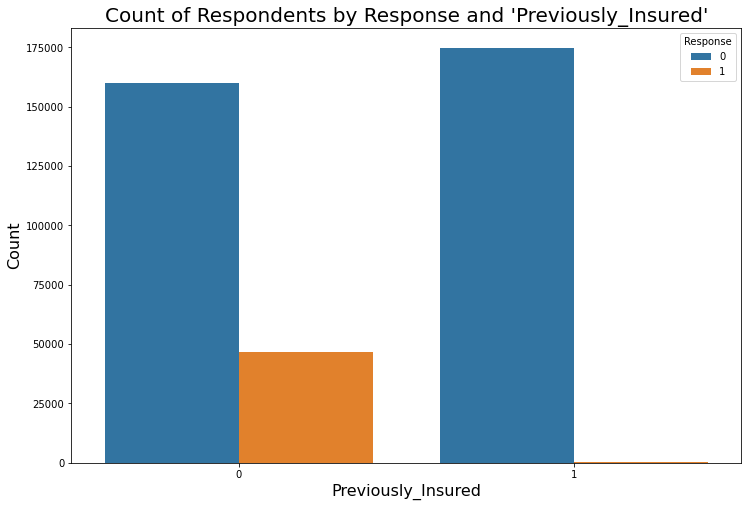

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

fig,ax1 = plt.subplots(nrows = 1, ncols = 1, sharex = False, figsize = (12, 8))
sns.barplot(PreviouslyInsuredCount['Previously_Insured'], PreviouslyInsuredCount["count"], hue = PreviouslyInsuredCount["Response"], ax = ax1, ci = None)
ax1.set_title("Count of Respondents by Response and 'Previously_Insured'", fontsize = 20)
ax1.set_xlabel('Previously_Insured',fontsize = 16); ax1.set_ylabel("Count",fontsize = 16)
plt.show()

### By Vehicle_Damage

Yes : Customer got his/her vehicle damaged in the past. No : Customer didn't get his/her vehicle damaged in the past.

In [29]:
NResPer=health.filter(health['Vehicle_Damage']== "No").filter(health['Response']=='1').count() /health.filter(health['Vehicle_Damage']== "No").count()
YResPer=health.filter(health['Vehicle_Damage']== "Yes").filter(health['Response']=='1').count()/health.filter(health['Vehicle_Damage']== 'Yes').count()
VDPer=health.filter(health['Vehicle_Damage']== "Yes").count() /health.count()

print(" Vehicle doesn't have been Damaged Response Rate  :",str(round(100 *NResPer,3)),"%")
print("Vehicle already have been Damaged  Response Rate :", str(round(100 *YResPer,3)),"%")
print("------------------------------------------------------------------")
print("Vehicle already have been Damaged Rate :", str(round(100 *VDPer,3)),"%")

 Vehicle doesn't have been Damaged Response Rate  : 0.52 %
Vehicle already have been Damaged  Response Rate : 23.766 %
------------------------------------------------------------------
Vehicle already have been Damaged Rate : 50.488 %


In [30]:
VDCount = health.groupBy(['Vehicle_Damage',"Response"]).count().toPandas()


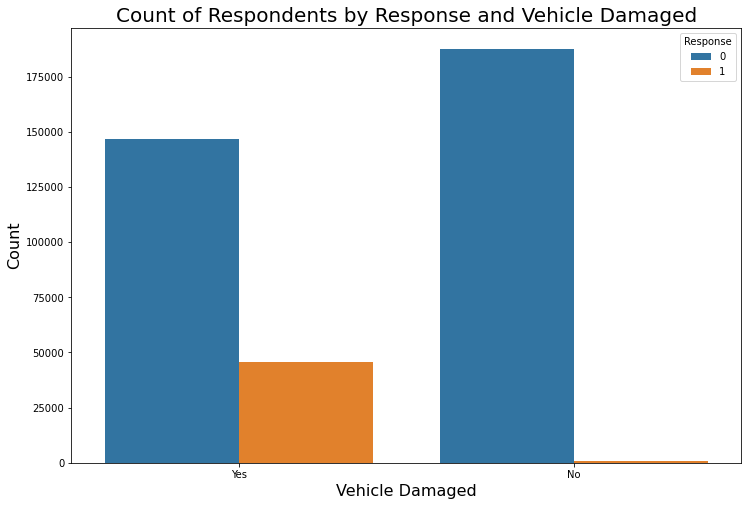

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

fig,ax1 = plt.subplots(nrows = 1, ncols = 1, sharex = False, figsize = (12, 8))
sns.barplot(VDCount['Vehicle_Damage'], VDCount["count"], hue = VDCount["Response"], ax = ax1, ci = None)
ax1.set_title("Count of Respondents by Response and Vehicle Damaged", fontsize = 20)
ax1.set_xlabel('Vehicle Damaged',fontsize = 16); ax1.set_ylabel("Count",fontsize = 16)
plt.show()

### Category Featuers

### By Vehicle_Age

In [32]:
vehicleStats = health.groupBy(["Vehicle_Age", "Response"]).count().toPandas()
premiumStats = health.groupBy(["Vehicle_Damage", "Vehicle_Age","Response"]).avg("Annual_Premium").withColumnRenamed("avg(Annual_Premium)","Avg_Annual_Premium").toPandas()

In [33]:
premiumStats

,Vehicle_Damage,Vehicle_Age,Response,Avg_Annual_Premium
0,No,1-2 Year,1,24648.181208
1,No,1-2 Year,0,30371.621162
2,No,< 1 Year,1,23169.699482
3,Yes,1-2 Year,1,31187.781000
4,Yes,< 1 Year,1,30204.459214
5,Yes,> 2 Years,0,34606.206554
6,No,< 1 Year,0,30475.963495
7,No,> 2 Years,0,15448.733333
8,Yes,1-2 Year,0,30434.702090
9,Yes,> 2 Years,1,38236.020842


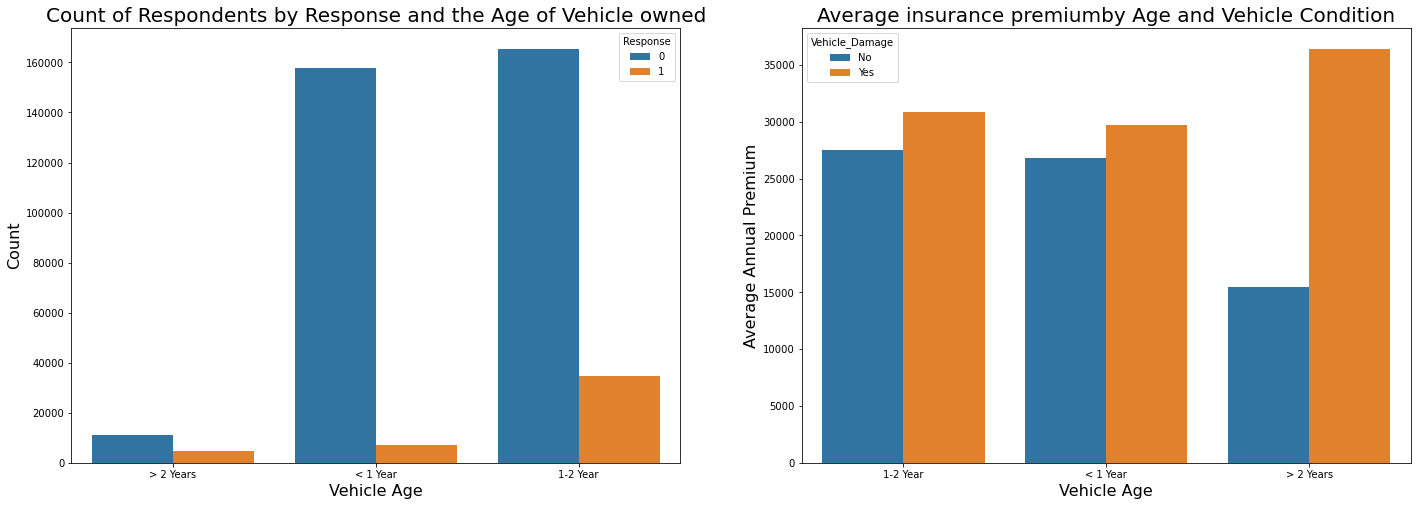

In [34]:
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, sharex = False, figsize = (24, 8))
sns.barplot(vehicleStats["Vehicle_Age"], vehicleStats["count"], hue = vehicleStats["Response"], ax = ax1, ci = None)
ax1.set_title("Count of Respondents by Response and the Age of Vehicle owned", fontsize = 20)
ax1.set_xlabel("Vehicle Age",fontsize = 16); ax1.set_ylabel("Count",fontsize = 16)
sns.barplot(premiumStats["Vehicle_Age"], premiumStats["Avg_Annual_Premium"], hue = premiumStats["Vehicle_Damage"],ax = ax2, ci = None)
ax2.set_xlabel("Vehicle Age",fontsize = 16); ax2.set_ylabel("Average Annual Premium",fontsize = 16)
ax2.set_title("Average insurance premiumby Age and Vehicle Condition", fontsize = 20)


plt.show()

### By Region_Code

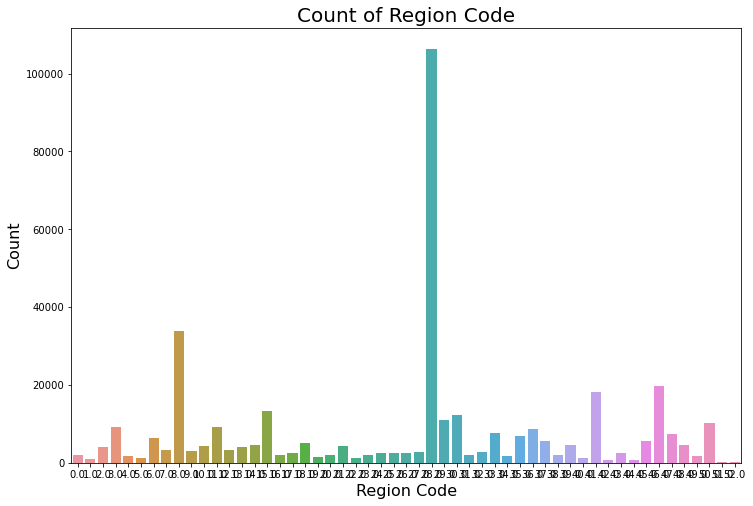

In [35]:
RCCount = health.groupBy(["Region_Code"]).count().toPandas()

fig,ax1 = plt.subplots(nrows = 1, ncols = 1, sharex = False, figsize = (12, 8))
sns.barplot(RCCount["Region_Code"], RCCount["count"], ax = ax1, ci = None)
ax1.set_title("Count of Region Code", fontsize = 20)
ax1.set_xlabel('Region Code',fontsize = 16); ax1.set_ylabel("Count",fontsize = 16)
plt.show()

### By PolicySalesChannel

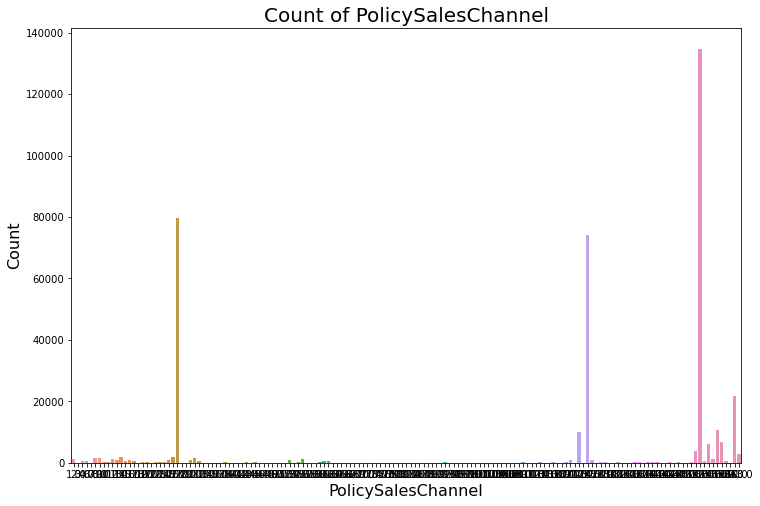

In [36]:
PSCCount = health.groupBy(["Policy_Sales_Channel"]).count().toPandas()

fig,ax1 = plt.subplots(nrows = 1, ncols = 1, sharex = False, figsize = (12, 8))
sns.barplot(PSCCount["Policy_Sales_Channel"], PSCCount["count"], ax = ax1, ci = None)
ax1.set_title("Count of PolicySalesChannel", fontsize = 20)
ax1.set_xlabel('PolicySalesChannel',fontsize = 16); ax1.set_ylabel("Count",fontsize = 16)
plt.show()

## Correlation Matrix

#### Turn features into numberics：'Vehicle_Damage','Gender'，"Vehicle_Age"

In [37]:

from pyspark.sql.functions import lit ,when
health = health.withColumn('Vehicle_Damage', when(health.Vehicle_Damage == 'No', lit(0)).otherwise(1))

health = health.withColumn('Gender', when(health.Gender == 'Male', lit(0)).otherwise(1))

health = health.withColumn('Vehicle_Age', when(health.Vehicle_Age == '< 1 Year', lit(1)).otherwise(health.Vehicle_Age))
health = health.withColumn('Vehicle_Age', when(health.Vehicle_Age == '1-2 Year', lit(2)).otherwise(health.Vehicle_Age))
health = health.withColumn('Vehicle_Age', when(health.Vehicle_Age == '> 2 Years', lit(3)).otherwise(health.Vehicle_Age))

health.select('Vehicle_Damage','Gender',"Vehicle_Age").show()

+--------------+------+-----------+
|Vehicle_Damage|Gender|Vehicle_Age|
+--------------+------+-----------+
|             1|     0|          3|
|             0|     0|          2|
|             1|     0|          3|
|             0|     0|          1|
|             0|     1|          1|
|             1|     1|          1|
|             1|     0|          1|
|             1|     1|          2|
|             0|     1|          1|
|             0|     1|          1|
|             1|     1|          2|
|             0|     1|          1|
|             0|     1|          2|
|             1|     0|          2|
|             0|     0|          2|
|             1|     0|          2|
|             1|     1|          1|
|             0|     1|          1|
|             1|     0|          2|
|             1|     1|          2|
+--------------+------+-----------+
only showing top 20 rows



In [38]:
df=health.select("Age",'Annual_Premium','Vintage',"Driving_License","Previously_Insured",'Vehicle_Damage','Gender',"Vehicle_Age","Response")

In [39]:
df.show()

+---+--------------+-------+---------------+------------------+--------------+------+-----------+--------+
|Age|Annual_Premium|Vintage|Driving_License|Previously_Insured|Vehicle_Damage|Gender|Vehicle_Age|Response|
+---+--------------+-------+---------------+------------------+--------------+------+-----------+--------+
| 44|       40454.0|    217|              1|                 0|             1|     0|          3|       1|
| 76|       33536.0|    183|              1|                 0|             0|     0|          2|       0|
| 47|       38294.0|     27|              1|                 0|             1|     0|          3|       1|
| 21|       28619.0|    203|              1|                 1|             0|     0|          1|       0|
| 29|       27496.0|     39|              1|                 1|             0|     1|          1|       0|
| 24|        2630.0|    176|              1|                 0|             1|     1|          1|       0|
| 23|       23367.0|    249|         

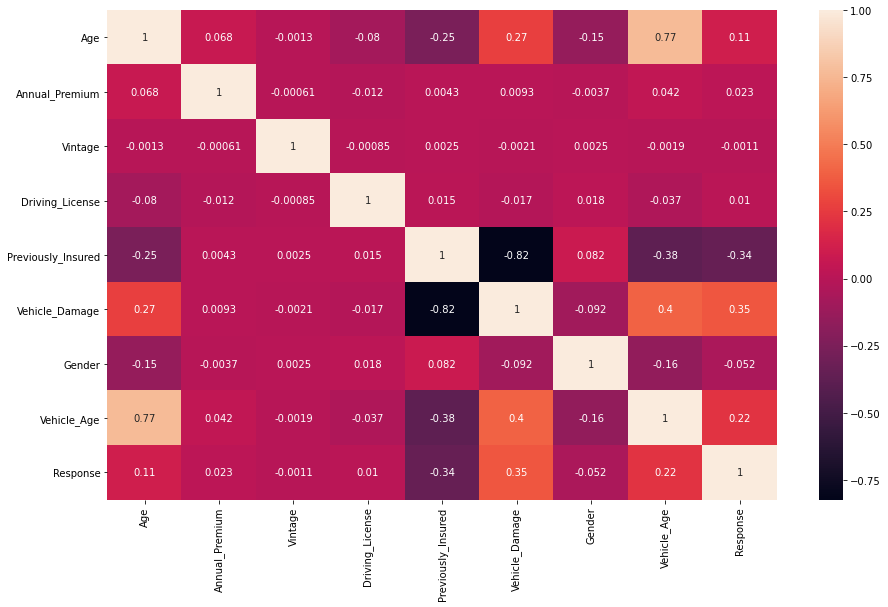

In [40]:
rdd = df.rdd.map(list)

from pyspark.mllib.stat import Statistics 
rdd_corr = rdd.map(lambda row: row)
corr_mat=Statistics.corr(rdd_corr, method="pearson")

fig, axs = plt.subplots(ncols=1,figsize=(15,9))
sns.heatmap(corr_mat,annot=True,xticklabels=["Age",'Annual_Premium','Vintage',"Driving_License","Previously_Insured",'Vehicle_Damage','Gender',"Vehicle_Age","Response"], yticklabels=["Age",'Annual_Premium','Vintage',"Driving_License","Previously_Insured",'Vehicle_Damage','Gender',"Vehicle_Age","Response"])